# Data manipulation

In [1]:
### All imports
import torch
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
#import

## Get data

In [2]:
### Setup dataset viarables and methods for data import
import os
current_dir = os.getcwd()
data_dir = os.path.join(os.path.dirname(current_dir), "datasets", "plain_text_wikipedia", "AllCombined.txt")  # Path to all data
colab_path = "/content/datasets/plain_text_wikipedia/AllCombined.txt"

def get_lines(file_path):
    """
    Args:
        file_path: path to file (.txt file only)
    Returns:
        all the lines found in given file
    """
    with open(file_path, "r") as f:
        return f.readlines()

In [3]:
### Importing and storing the data into a variable
# all_data = get_lines(colab_path)
all_data = get_lines(data_dir)
print(f"Random line from the dataset:\n{all_data[60]}")  # Fixed position to 60 | many times the line is "\n"
print(f"Number of lines: {len(all_data)}")

Random line from the dataset:
Some people say that art is a product or item that is made with the intention of stimulating the human senses as well as the human mind, spirit and soul. An artwork is normally judged by how much impact it has on people, the number of people who can relate to it, and how much they appreciate it. Some people also get inspired.

Number of lines: 2052699


## Getting the data ready

### Create a df for the lines

In [4]:
### Store data in a dataframe
all_data_df = pd.DataFrame(data=all_data, columns=["text"])  # Create df
all_data_df["word_count"] = all_data_df["text"].apply(lambda x: len(x.split()))  # Get word counts per line
all_data_df.head()

,text,word_count
0,\n,0
1,April\n,1
2,\n,0
3,April (Apr.) is the fourth month of the year i...,31
4,\n,0


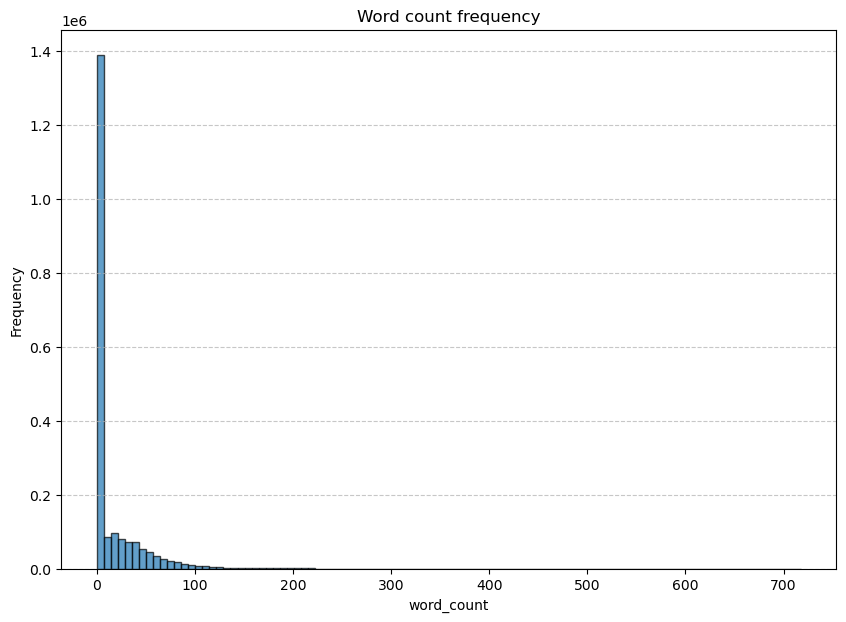

In [5]:
### Plot a histogram w/word_count
def plot_word_count(df: pd.DataFrame):
    """
    Plots a histogram wrt the word_count col in df.

    Args:
        df: DataFrame instance with "word_count" col
    """
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 7))
    plt.hist(df["word_count"], bins=100, edgecolor='black', alpha=0.7,)
    plt.title("Word count frequency")
    plt.xlabel("word_count")
    plt.ylabel("Frequency")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show();

plot_word_count(all_data_df)

There are many lines that have word_count = 0.\
All of these lines have the string "\n".\
We will be removing most of these lines, by keeping the lines with word_count = 0 when the next line has a non-zero word_count.\
<br>
We are keeping some empty lines, since the model will have to learn when to add an extra/empty line to seperate text outputs.

### Filtering new-lines

In [6]:
def filter_empty_lines(df: pd.DataFrame):
    """
    Filters out most of the lines with an empty line in the df.
    Keeps all the empty lines if next line is non-empty.

    Args:
        df: DataFrame instance with the "line" and "word_count" columns
    Returns:
        Filtered df.
    """
    filtered_idx = []
    prev_non_zero = False
    len_df = len(df)

    for i in range(len_df):
        if df.loc[i, "word_count"] == 0:
            if not prev_non_zero and i+1<len_df and df.loc[i+1, "word_count"] > 0:
                filtered_idx.append(i)
            prev_non_zero = False
        else:
            filtered_idx.append(i)
            prev_non_zero = True
        
    return df.loc[filtered_idx]

def filter_empty_lines_for_paragraphs(df):
    """
    Removes unnecessary empty lines (word_count == 0).
    While preserving those between paragraphs (separating sequences of non-zero word count lines).

    Args:
        df: DataFrame with a 'word_count' column.

    Returns:
        Filtered df.
    """
    filtered_indices = []
    len_df = len(df)
    
    for i in range(len_df):
        if df.loc[i, 'word_count'] == 0:
            if (i > 0 and df.loc[i - 1, 'word_count'] > 0) and \
               (i + 1 < len_df and df.loc[i + 1, 'word_count'] > 0):
                filtered_indices.append(i)
        else:
            filtered_indices.append(i)
    
    return df.loc[filtered_indices].reset_index(drop=True)


In [7]:
#all_data_df_filtered = filter_empty_lines(all_data_df)
all_data_df_filtered = filter_empty_lines_for_paragraphs(all_data_df)
all_data_df_filtered.head(10)

,text,word_count
0,April\n,1
1,\n,0
2,April (Apr.) is the fourth month of the year i...,31
3,\n,0
4,April always begins on the same day of the wee...,30
5,\n,0
6,"April comes between March and May, making it t...",40
7,\n,0
8,April begins on the same day of the week as Ju...,51
9,\n,0


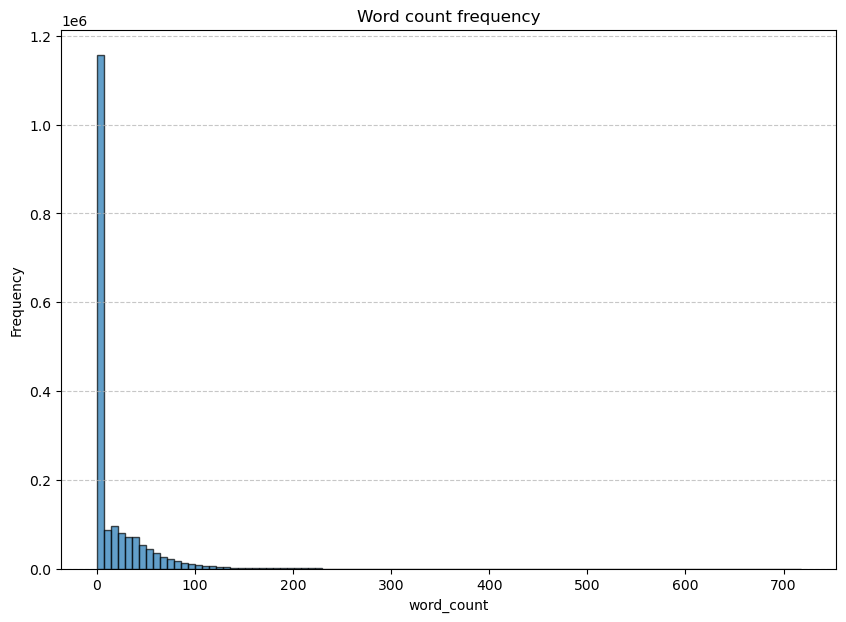

In [8]:
plot_word_count(all_data_df_filtered)

In [9]:
all_data_df_filtered[all_data_df_filtered["word_count"] > 600]

,text,word_count
340380,"In English culture, the Phoenix is ​​a mythica...",659
340410,Phoenix Short Story by Sylvia Town Sand Warner...,718
704121,Hershel tells Rick and his group that they hav...,636
1214309,Contreras first joined the UDP in 1997 when he...,654
1229308,Willis Seward Keith has graduated Princeton Un...,646
1410423,Hayainu's mother had died when Hayainu was a y...,679
1487861,Once there lived a widowed lady with her three...,647
1559111,"On a Swedish country farm, a cat gives birth t...",611
1804461,In Chuacers The Canterbury Tales the 3rd Tale ...,625


In [10]:
all_data_df_filtered.sort_values(by="word_count", ascending=True, inplace=False)

,text,word_count
910749,\n,0
578780,\n,0
1201032,\n,0
578782,\n,0
1201029,\n,0
...,...,...
1487861,Once there lived a widowed lady with her three...,647
1214309,Contreras first joined the UDP in 1997 when he...,654
340380,"In English culture, the Phoenix is ​​a mythica...",659
1410423,Hayainu's mother had died when Hayainu was a y...,679


In [11]:
len_all_data = len(all_data_df)
len_new_line_filtered = len(all_data_df_filtered)
print(f"Number of lines filtered (deleted): {len_all_data - len_new_line_filtered}")

Number of lines filtered (deleted): 231199


### General preprocessing

Go to `scripts/english_lang_preprocessing.py` for the code.\
Go to `datasets/preprocessing/english_lang.txt` for the output of the above script.
<br></br>
***Note***: running this code as a .py script, since multiprocessing.Pool needs to be defined at the top of the file and may not work well in a jupyter env. sooo... yeah.

In [56]:
### Saving the current dataset as a .txt file
# Get path
from pathlib import Path
current_dir = Path(current_dir)
save_dir = current_dir.parent / "datasets" / "preprocessing"

# Create dir if not already
os.makedirs(save_dir, exist_ok=True)

# Save to path
all_data_df_filtered.to_csv(save_dir / "empty_lines_filtered.csv", encoding="utf-8")#, index=False)

In [ ]:
#### Code for the script

### Language detection
from langdetect import detect, LangDetectException
from multiprocessing import Pool
from pathlib import Path
import pandas as pd
import numpy as np
import re
import os

def is_valid_line(line: str) -> bool:
    """
    Quickly checks if the line is valid without detecting the language.

    Args:
        line: line to check on
    Returns:
        True if line is valid
        False if otherwise
        None if more processing is requeried
    """
    line = line.strip()
    if not line:
        return False
    if re.fullmatch(r"[\d\s\W]+", line):
        return True
    return None

def detect_line(line: str) -> bool:
    """
    Detects if a line contains only English words, keeping numerical data and symbols.

    Args:
        line: single line to check
    Returns:
        bool, True if line belongs to english, else False
    """ 
    if (result := is_valid_line(line)) is not None:
        return result
    try:
        return detect(line) == "en"
    except LangDetectException as e:
        print(f"[ERROR] Unable to detect language for line:\n'{line}'\nError: {e}\n")
        return False
    except Exception as e:
        print(f"[ERROR] Unexpected error for line:\n'{line}'\nError: {e}\n")
        return False

def process_chunk(chunk):
    """
    Process a chunk of the DataFrame for English lines
    """
    return chunk[chunk["text"].apply(detect_line)]

def main():
    ### Load data
    # Setup path to get data
    current_dir = os.getcwd()
    current_dir = Path(current_dir)
    data_dir = current_dir / "datasets" / "preprocessing" / "empty_lines_filtered.csv"
    # Load data into df
    all_data_df_filtered = pd.read_csv(data_dir)

    ### Get all valid lines (using multiprocessing)
    num_workers = os.cpu_count()
    chunk_size = num_workers
    chunks = np.array_split(all_data_df_filtered, chunk_size)

    with Pool(processes=chunk_size) as pool:
        results = pool.map(process_chunk, chunks)

    # Store into df
    english_data_df = pd.concat(results, ignore_index=True)
    # Save df to path
    output_dir = current_dir / "datasets" / "preprocessing"
    output_dir.mkdir(parents=True, exist_ok=True)
    output_file = output_dir / "english_lang.csv"
    english_data_df.to_csv(output_file, encoding="utf-8")
    print(f"Preprocessed and saved to: {output_file}")

if __name__ == "__main__":
    main()

In [63]:
### Loading preprocessed data
load_dir = current_dir.parent / "datasets" / "preprocessing" / "english_lang.csv"
english_data_df = pd.read_csv(load_dir)
english_data_df.drop(["Unnamed: 0.1", "Unnamed: 0"], axis=1, inplace=True)
english_data_df.head()

,text,word_count
0,April (Apr.) is the fourth month of the year i...,31
1,April always begins on the same day of the wee...,30
2,"April comes between March and May, making it t...",40
3,April begins on the same day of the week as Ju...,51
4,"In common years, April starts on the same day ...",103


In [64]:
len(english_data_df)

795271

In [65]:
english_data_df.sort_values(by=["word_count"], ascending=True, inplace=False)

,text,word_count
197530,150||49\n,1
620000,Sexology\n,1
162985,Subsidiarity\n,1
648733,Tincourt-Boucly\n,1
72076,100s\n,1
...,...,...
657842,Once there lived a widowed lady with her three...,647
545083,Contreras first joined the UDP in 1997 when he...,654
161055,"In English culture, the Phoenix is ​​a mythica...",659
626952,Hayainu's mother had died when Hayainu was a y...,679


In [68]:
len_english_lang_filtered = len(english_data_df)
print(f"Number of rows deleted (wrt prev filter):\t{len_new_line_filtered - len_english_lang_filtered}")
print(f"Number of rows deleted (wrt all data):\t\t{len_all_data - len_english_lang_filtered}")

Number of rows deleted (wrt prev filter):	1026229
Number of rows deleted (wrt all data):		1257428


There is a problem with the current state of the filtered data...\
All the **"\n" (empty lines)** lines/entries have been droped duing filteration for the English language.\
This will cause a problem in the future, during model-evaluation, as the model's outputs may not be desireable for the user.\
However, I will be changing the preprocessing approach in a future revision. Since the cost of running the preprocessing script is high (load my laptop a bit too much).
<br></br>
But for the most part, this looks fine for now